![](https://europe-west1-atp-views-tracker.cloudfunctions.net/working-analytics?notebook=tutorials--agent-memory-with-redis--agent-memory-tutorial)

# Agent Memory with Redis

## 🚀 Run in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NirDiamant/agents-towards-production/blob/main/tutorials/agent-memory-with-redis/agent_memory_tutorial.ipynb)


## Introduction

Without memory, AI agents are like goldfish - they forget everything after each conversation and can't learn from past interactions or maintain context across sessions. Agentic systems require both **short-term** and **long-term** memory in order to complete tasks in a personalized and resilient manner. Memory is all about state management and [**Redis**](https://redis.io/try-free/?utm_source=nir&utm_medium=cpa&utm_campaign=2025-05-ai_in_production-influencer-nir&utm_content=sd-software_download-7013z000001WaRY) is the well-known in-memory database for exactly this kind of use case today in production systems.

## What We'll Build

This notebook demonstrates how to build a **memory-enabled travel agent** with **Redis** and **LangGraph** that remembers user preferences and provides personalized recommendations. This is a **horizontal concept** that you can take and apply to your own agent use cases.

We'll explore:

1. Short-term memory management using LangGraph's checkpointer
2. Long-term memory storage and retrieval using RedisVL
3. Managing long-term memory as a tool for a ReAct agent
4. Managing conversation history size with summarization

# 🧠 Memory architecture overview

Our agent uses a dual-memory system:
- **Short-term**: Manages conversation context
- **Long-term**: Stores persistent knowledge

## Short-term Memory
The agent tracks chat history using Redis through LangGraph's [checkpointer](https://github.com/redis-developer/langgraph-redis). Each node in the graph (Retrieve Memories, Respond, Summarize) saves its state to Redis, including conversation history and thread metadata.

<img src="https://github.com/NirDiamant/agents-towards-production/blob/main/tutorials/agent-memory-with-redis/assets/short-term-memory.png?raw=1" width="400" alt="Short-term Memory Diagram">

To prevent context window pollution, the agent summarizes conversations when they exceed a configurable length.

## Long-term Memory

Long-term memories are stored & indexed in Redis using the RedisVL client, with two types:
- **Episodic**: User preferences and experiences
- **Semantic**: General travel knowledge

<img src="https://github.com/NirDiamant/agents-towards-production/blob/main/tutorials/agent-memory-with-redis/assets/long-term-memory.png?raw=1" width="600" alt="Long-term Memory Diagram">

>**NOTE**: These memory types align with the [CoALA](https://arxiv.org/abs/2309.02427) paper's concepts. Our agent's procedural memory is encoded in its Python workflow.

---

# Set up our environment

Before diving into the code, let's set up our development environment with the right Python libraries.

>**NOTE**: You may need to restart your kernel after installing libraries.

In [ ]:
%pip install langchain-openai langgraph-checkpoint langgraph langgraph-checkpoint-redis langchain-redis

## Required API keys

You must add an [OpenAI API](https://platform.openai.com/signup) key with billing information for this tutorial.

In [51]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ or os.environ[key] == "" :
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

## Setup Redis

You have two options for running Redis:

1. **Redis Cloud**: For a fully-managed, seamless experience, use [a free instance of Redis Cloud](https://redis.io/try-free/?utm_source=nir&utm_medium=cpa&utm_campaign=2025-05-ai_in_production-influencer-nir&utm_content=sd-software_download-7013z000001WaRY).
2. **Local Redis**: For a simple, local (non-persistent) Redis instance, run the cell below.

Run the cell below to get a localized Redis instance on your Google colab server.

In [52]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


gpg: cannot open '/dev/tty': No such device or address
curl: (23) Failed writing body


Let's test out Redis connection and create a client to communicate with the server.

In [53]:
import os

from redis import Redis

# Use the environment variable if set, otherwise default to localhost
REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")

redis_client = Redis.from_url(REDIS_URL)
redis_client.ping()

True

## Prepare memory data models

In this section, we'll create a robust data modeling system for our agent's memory using `Pydantic`. These models will ensure type safety and provide clear data structures for storing and retrieving memories from Redis.

We'll implement four key components:

1. `MemoryType` - An enumeration that categorizes memories into two types:
   - Episodic: Personal experiences and user preferences
   - Semantic: General knowledge and domain facts

2. `Memory` - The core model representing a single memory entry with its content and metadata

3. `Memories` - A container model that holds collections of memory objects

4. `StoredMemory` - A specialized model for memories that have been persisted to Redis

These models work together to create a complete memory lifecycle, from creation to storage and retrieval.

In [54]:
import ulid

from datetime import datetime
from enum import Enum
from typing import List, Optional
from pydantic import BaseModel, Field


class MemoryType(str, Enum):
    """
    Defines the type of long-term memory for categorization and retrieval.

    EPISODIC: Personal experiences and user-specific preferences
              (e.g., "User prefers Delta airlines", "User visited Paris last year")

    SEMANTIC: General knowledge on top of the user's preferences and LLM's
    training data.
              (e.g., "Singapore requires passport", "Tokyo has excellent public transit")
    """

    EPISODIC = "episodic"
    SEMANTIC = "semantic"


class Memory(BaseModel):
    """Represents a single long-term memory."""

    content: str
    memory_type: MemoryType
    metadata: str


class Memories(BaseModel):
    """
    A list of memories extracted from a conversation by an LLM.

    NOTE: OpenAI's structured output requires us to wrap the list in an object.
    """

    memories: List[Memory]


class StoredMemory(Memory):
    """A stored long-term memory"""

    id: str  # The redis key
    memory_id: ulid.ULID = Field(default_factory=lambda: ulid.ULID())
    created_at: datetime = Field(default_factory=datetime.now)
    user_id: Optional[str] = None
    thread_id: Optional[str] = None
    memory_type: Optional[MemoryType] = None

Now we have type-safe data models that handle the complete memory lifecycle from LLM extraction to Redis storage, with proper metadata tracking for production use. Next, we'll set up the Redis infrastructure to store and search these memories using vector embeddings.

# Memory Storage

- **Short-term memory** is handled automatically by `RedisSaver` from `langgraph-checkpoint-redis`.
- For **long-term memory**, we'll use RedisVL with vector embeddings to enable semantic search of past experiences and knowledge.

Below, we will create a search index schema in Redis to hold our long term memories. The schema has a few different fields including content, memory type, metadata, timestamps, user id, memory id, and the embedding of the memory.

In [55]:
from redisvl.index import SearchIndex
from redisvl.schema.schema import IndexSchema


# Define the schema for our vector search index
# This creates the structure for storing and querying memories
memory_schema = IndexSchema.from_dict({
        "index": {
            "name": "agent_memories",  # Index name for identification
            "prefix": "memory",       # Redis key prefix (memory:1, memory:2, etc.)
            "key_separator": ":",
            "storage_type": "json",
        },
        "fields": [
            {"name": "content", "type": "text"},
            {"name": "memory_type", "type": "tag"},
            {"name": "metadata", "type": "text"},
            {"name": "created_at", "type": "text"},
            {"name": "user_id", "type": "tag"},
            {"name": "memory_id", "type": "tag"},
            {
                "name": "embedding",
                "type": "vector",
                "attrs": {
                    "algorithm": "flat",
                    "dims": 1536,  # OpenAI embedding dimension
                    "distance_metric": "cosine",
                    "datatype": "float32",
                },
            },
        ],
    }
)

Below we create the `SearchIndex` from the `IndexSchema` and our Redis client connection object. We will overwrite the index spec if its already created!

In [56]:
try:
    long_term_memory_index = SearchIndex(
        schema=memory_schema,
        redis_client=redis_client,
        validate_on_load=True
    )
    long_term_memory_index.create(overwrite=True)
    print("Long-term memory index ready")
except Exception as e:
    print(f"Error creating index: {e}")

Long-term memory index ready


Now that the index is created, we can inspect the long term memory index in Redis using the `rvl` cli:

In [57]:
!rvl index info -i agent_memories



Index Information:
╭────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬╮
│ Index Name     │ Storage Type   │ Prefixes       │ Index Options  │ Indexing       │
├────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼┤
| agent_memories | JSON           | ['memory']     | []             | 0              |
╰────────────────┴────────────────┴────────────────┴────────────────┴────────────────┴╯
Index Fields:
╭─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬╮
│ Name            │ Attribute       │ Type            │ Field Option    │ Option Value    │ Field Option    │ Option Value    │ Field Option    │ Option Value    │ Field Option    │ Option Value    │
├─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────

## Functions to access memories

Next, we provide three core functions to access, store and retrieve memories. We will eventually use these in tools for the LLM to call. We will start by loading a vectorizer class to create OpenAI embeddings.


In [58]:
from redisvl.utils.vectorize.text.openai import OpenAITextVectorizer

openai_embed = OpenAITextVectorizer(model="text-embedding-ada-002")

Next we will set up a simple logger so our functions will record log activity of what's happening.

In [59]:
import logging

# Set up a logger
logger = logging.getLogger(__name__)

### 1. Check for similar memories
First, we'll write a utility function to check if a memory similar to a given
memory already exists in the index.

This function checks for duplicate memories in Redis by:
1. Converting the input content into a vector embedding
2. Creating filters for user_id and memory_type
3. Using vector similarity search with a vector range query to find any existing + similar memories
4. Returning True if a similar memory exists, False otherwise

This helps prevent storing redundant information in the agent's memory.

In [60]:
from redisvl.query import VectorRangeQuery
from redisvl.query.filter import Tag


# If we have any memories that aren't associated with a user, we'll use this ID.
SYSTEM_USER_ID = "system"


def similar_memory_exists(
    content: str,
    memory_type: MemoryType,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    distance_threshold: float = 0.1,
) -> bool:
    """Check if a similar long-term memory already exists in Redis."""
    content_embedding = openai_embed.embed(content)

    filters = (Tag("user_id") == user_id) & (Tag("memory_type") == memory_type)

    if thread_id:
        filters = filters & (Tag("thread_id") == thread_id)

    # Search for similar memories
    vector_query = VectorRangeQuery(
        vector=content_embedding,
        num_results=1,
        vector_field_name="embedding",
        filter_expression=filters,
        distance_threshold=distance_threshold,
        return_fields=["id"],
    )
    results = long_term_memory_index.query(vector_query)
    logger.debug(f"Similar memory search results: {results}")

    if results:
        logger.debug(
            f"{len(results)} similar {'memory' if results.count == 1 else 'memories'} found. First: "
            f"{results[0]['id']}. Skipping storage."
        )
        return True

    return False

### 2. Store long-term memories

Below is a function that handles storing long-term memories in Redis with built-in deduplication.

It's a key part of our memory system that:
1. Prevents duplicate memories by checking for similar content
2. Creates vector embeddings for semantic search capabilities
3. Stores the memory with relevant metadata for future retrieval

We'll use the `similar_memory_exists()` function when we store memories in order to perform in-line memory deduplication.

In [61]:


from datetime import datetime
from typing import List, Optional, Union

import ulid


def store_memory(
    content: str,
    memory_type: MemoryType,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    metadata: Optional[str] = None,
):
    """Store a long-term memory in Redis with deduplication.

        This function:
        1. Checks for similar existing memories to avoid duplicates
        2. Generates vector embeddings for semantic search
        3. Stores the memory with metadata for retrieval
        """
    if metadata is None:
        metadata = "{}"

    logger.info(f"Preparing to store memory: {content}")

    if similar_memory_exists(content, memory_type, user_id, thread_id):
        logger.info("Similar memory found, skipping storage")
        return

    embedding = openai_embed.embed(content)

    memory_data = {
        "user_id": user_id or SYSTEM_USER_ID,
        "content": content,
        "memory_type": memory_type.value,
        "metadata": metadata,
        "created_at": datetime.now().isoformat(),
        "embedding": embedding,
        "memory_id": str(ulid.ULID()),
        "thread_id": thread_id,
    }

    try:
        long_term_memory_index.load([memory_data])
    except Exception as e:
        logger.error(f"Error storing memory: {e}")
        return

    logger.info(f"Stored {memory_type} memory: {content}")

### 3. Retrieve relevant long-term memories
And now that we're storing memories, we can retrieve them using vector similarity search with metadata filters using RedisVL.

This function:
1. Takes a query string, optional filters (memory type, user ID, thread ID), and a distance threshold (semantic)
2. Creates a vector range query using the query's embedding
3. Builds a filter object based on passed options
4. Filters to narrow down the search results
4. Executes the search and returns parsed memory objects

In [62]:
def retrieve_memories(
    query: str,
    memory_type: Union[Optional[MemoryType], List[MemoryType]] = None,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    distance_threshold: float = 0.1,
    limit: int = 5,
) -> List[StoredMemory]:
    """Retrieve relevant memories from Redis using vector similarity search.

    """
    # Create vector query using query embedding
    logger.debug(f"Retrieving memories for query: {query}")
    vector_query = VectorRangeQuery(
        vector=openai_embed.embed(query),
        return_fields=[
            "content",
            "memory_type",
            "metadata",
            "created_at",
            "memory_id",
            "thread_id",
            "user_id",
        ],
        num_results=limit,
        vector_field_name="embedding",
        dialect=2,
        distance_threshold=distance_threshold,
    )

    # Build filter conditions
    base_filters = [f"@user_id:{{{user_id or SYSTEM_USER_ID}}}"]

    if memory_type:
        if isinstance(memory_type, list):
            base_filters.append(f"@memory_type:{{{'|'.join(memory_type)}}}")
        else:
            base_filters.append(f"@memory_type:{{{memory_type.value}}}")

    if thread_id:
        base_filters.append(f"@thread_id:{{{thread_id}}}")

    vector_query.set_filter(" ".join(base_filters))

    # Execute vector similarity search
    results = long_term_memory_index.query(vector_query)

    # Parse results into StoredMemory objects
    memories = []
    for doc in results:
        try:
            memory = StoredMemory(
                id=doc["id"],
                memory_id=doc["memory_id"],
                user_id=doc["user_id"],
                thread_id=doc.get("thread_id", None),
                memory_type=MemoryType(doc["memory_type"]),
                content=doc["content"],
                created_at=doc["created_at"],
                metadata=doc["metadata"],
            )
            memories.append(memory)
        except Exception as e:
            logger.error(f"Error parsing memory: {e}")
            continue
    return memories

## 🛠️ Managing Long-Term Memory with Tools

Memory operations are exposed as **tools** that the LLM can call to store or retrieve memories.

**Tool-based memory management:**
- LLM decides when to store/retrieve memories
- Fewer Redis calls but may miss some context
- Adds some latency due to LLM decision-making

Alternatively, you can always manually manage memories in your workflows.

**Manual memory management:**
- More Redis calls but faster response times
- Extracts more memories, providing richer context
- Higher token usage due to more context

> NOTE: **This notebook uses tool-based memory** for optimal balance of control and efficiency.

<img src="https://github.com/NirDiamant/agents-towards-production/blob/main/tutorials/agent-memory-with-redis/assets/memory-agents.png?raw=1" width="600" alt="Memory Agents Diagram">

### Define Agent Tools

Now that we have our storage functions defined, we can create the tools that will enable our agent to interact with the memory system. These tools will be used by the LLM to manage memories during conversations.

Let's start with the Store Memory Tool:

#### Store Memory Tool

This tool enables the agent to save important information as long-term memories in Redis. It's particularly useful for capturing:
- User preferences and habits
- Personal experiences and anecdotes
- Important facts and knowledge shared during conversations

The tool accepts the following parameters:
- `content`: The actual memory content to store (e.g., "User prefers window seats on flights")
- `memory_type`: The type of memory (e.g., `MemoryType.EPISODIC` for personal experiences, `MemoryType.SEMANTIC` for general knowledge)
- `metadata`: Optional dictionary for additional context (e.g., timestamps, source, confidence)
- `config`: Optional configuration for user/thread context (automatically handled by the agent)

When called, the tool:
1. Validates the input parameters
2. Stores the memory in Redis with proper indexing
3. Returns a success message with the stored content
4. Handles errors gracefully with informative messages

This tool is designed to be used by the LLM to build a persistent memory of the user's preferences and experiences, enabling more personalized and context-aware interactions over time.

In [63]:
from typing import Dict, Optional

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig


@tool
def store_memory_tool(
    content: str,
    memory_type: MemoryType,
    metadata: Optional[Dict[str, str]] = None,
    config: Optional[RunnableConfig] = None,
) -> str:
    """
    Store a long-term memory in the system.

    Use this tool to save important information about user preferences,
    experiences, or general knowledge that might be useful in future
    interactions.
    """
    config = config or RunnableConfig()
    user_id = config.get("user_id", SYSTEM_USER_ID)
    thread_id = config.get("thread_id")

    try:
        # Store in long-term memory
        store_memory(
            content=content,
            memory_type=memory_type,
            user_id=user_id,
            thread_id=thread_id,
            metadata=str(metadata) if metadata else None,
        )

        return f"Successfully stored {memory_type} memory: {content}"
    except Exception as e:
        return f"Error storing memory: {str(e)}"


Test the tool:

In [64]:
store_memory_tool.invoke({"content": "I like flying on Delta when possible", "memory_type": "episodic"})

INFO:__main__:Preparing to store memory: I like flying on Delta when possible
INFO:__main__:Stored MemoryType.EPISODIC memory: I like flying on Delta when possible


'Successfully stored MemoryType.EPISODIC memory: I like flying on Delta when possible'

Now that we've seen how to store memories, let's look at how to retrieve them.

#### Retrieve Memories Tool
This tool allows us to search through our stored memories using semantic similarity and filtering.

This tool is particularly useful when you want to:
- Find relevant past experiences or preferences
- Filter memories by type (episodic or semantic)
- Get user-specific information
- Limit the number of results to keep responses focused

The tool works by:
1. Taking a query string and searching for semantically similar memories
2. Filtering results based on memory type
3. Applying a similarity threshold to ensure relevance
4. Formatting the results in a clear, readable way

In [65]:
@tool
def retrieve_memories_tool(
    query: str,
    memory_type: List[MemoryType],
    limit: int = 5,
    config: Optional[RunnableConfig] = None,
) -> str:
    """
    Retrieve long-term memories relevant to the query.

    Use this tool to access previously stored information about user
    preferences, experiences, or general knowledge.
    """
    config = config or RunnableConfig()
    user_id = config.get("user_id", SYSTEM_USER_ID)

    try:
        # Get long-term memories
        stored_memories = retrieve_memories(
            query=query,
            memory_type=memory_type,
            user_id=user_id,
            limit=limit,
            distance_threshold=0.3,
        )

        # Format the response
        response = []

        if stored_memories:
            response.append("Long-term memories:")
            for memory in stored_memories:
                response.append(f"- [{memory.memory_type}] {memory.content}")

        return "\n".join(response) if response else "No relevant memories found."

    except Exception as e:
        return f"Error retrieving memories: {str(e)}"

Test the tool:

In [66]:
retrieve_memories_tool.invoke({"query": "Airline preferences", "memory_type": ["episodic"]})

'Long-term memories:\n- [MemoryType.EPISODIC] I like flying on Delta when possible'

# 🌎 Build the Travel Agent

## Setting Up the ReAct Agent

We'll use LangGraph's prebuilt components to create a ReAct agent with memory capabilities:

1. **Short-term Memory**: A checkpoint saver tracks conversation history per thread
2. **Long-term Memory**: We'll extract and store key information from conversations
   - Episodic memories: User preferences and experiences
   - Semantic memories: General travel knowledge

The system will automatically summarize conversations to manage context while preserving important details in long-term storage.

Below we start with setting up the Redis checkpointer (`RedisSaver`) that will handle short term memory for the agent.

In [67]:
from langchain_core.messages import AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langgraph.checkpoint.redis import RedisSaver

# Set up the Redis checkpointer for short term memory
redis_saver = RedisSaver(redis_client=redis_client)
redis_saver.setup()

Next we define the set of tools for the agent.

In [68]:
# Define the set of tools
tools = [store_memory_tool, retrieve_memories_tool]

Configure the LLM from OpenAI.

In [20]:
# Configure an LLM for the agent with a more creative temperature.
llm = ChatOpenAI(model="gpt-5", temperature=0.7).bind_tools(tools)

Assemble the ReAct agent combining the LLM, tools, checkpointer, and system prompt!

In [32]:
# Define the travel agent
travel_agent = create_agent(
    model=llm,
    tools=tools,               # Long-term memory: provided as a set of custom tools
    checkpointer=redis_saver,  # Short-term memory: the conversation history
    system_prompt=SystemMessage(
        content="""
        You are a travel assistant helping users plan their trips. You remember user preferences
        and provide personalized recommendations based on past interactions.

        You have access to the following types of memory:
        1. Short-term memory: The current conversation thread
        2. Long-term memory:
           - Episodic: User preferences and past trip experiences (e.g., "User prefers window seats")
           - Semantic: General knowledge about travel destinations and requirements

        Your procedural knowledge (how to search, book flights, etc.) is built into your tools and prompts.

        Always be helpful, concise, personal, and context-aware in your responses.
        """
    ),
)

✅ Now that we have the basic agent in place, we will build a LangGraph workflow that invokes this agent as a node. The graph will consist of three nodes in total. We will move through each one separately.

## Node 1: Respond to the user
In LangGraph, a **node** represents a discrete unit of processing in a workflow. Each node is a function that takes a state object and configuration as input, processes the data, and returns an updated state. Nodes can be connected to form a directed graph that defines the flow of execution.

The `respond_to_user` node (below) is our first node in the travel agent workflow. It serves as the entry point for user interactions and handles the core conversation flow. Here's how it works:

1. It receives the current conversation state and configuration
2. Extracts any human messages from the state
3. Invokes our travel agent to generate a response
4. Handles any errors gracefully
5. Updates the conversation state with the agent's response

The node uses a custom `RuntimeState` class that inherits from `MessagesState` to maintain the conversation history. This state object is passed between nodes in the graph, allowing each node to access and modify the conversation context as needed.

In [33]:

from langchain_core.messages import HumanMessage
from langgraph.graph.message import MessagesState


class RuntimeState(MessagesState):
    """Runtime state for the travel agent."""
    pass


def respond_to_user(state: RuntimeState, config: RunnableConfig) -> RuntimeState:
    """Invoke the travel agent to generate a response."""
    human_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]
    if not human_messages:
        logger.warning("No HumanMessage found in state")
        return state

    try:
        # Single agent invocation, not streamed (simplified for reliability)
        result = travel_agent.invoke({"messages": state["messages"]}, config=config)
        agent_message = result["messages"][-1]
        state["messages"].append(agent_message)
    except Exception as e:
        logger.error(f"Error invoking travel agent: {e}")
        agent_message = AIMessage(
            content="I'm sorry, I encountered an error processing your request."
        )
        state["messages"].append(agent_message)

    return state

## Node 2: Execute Tools

The `execute_tools` node is a critical component in our travel agent's workflow that bridges the gap between the LLM's decisions and actual tool execution. Positioned after the `respond_to_user` node, it handles the practical side of the agent's tool-using capabilities.

When the LLM determines it needs to use a tool, it includes tool calls in its response. This node then:

1. Scans the conversation history to find the most recent AI message containing tool calls
2. For each tool call found:
   - Extracts the tool name, arguments, and call ID from the message
   - Matches the tool name against our available tools
   - Executes the tool with the provided arguments
   - Creates a ToolMessage containing the result
3. Handles any errors that occur during tool execution
4. Adds all tool results back to the conversation history

This node is essential because it enables our agent to interact with external systems and services while maintaining a coherent conversation flow. Without it, the agent would be limited to just generating text responses without the ability to perform actual actions or retrieve real-time information.


In [34]:
from langchain_core.messages import ToolMessage


def execute_tools(state: RuntimeState, config: RunnableConfig) -> RuntimeState:
    """Execute tools specified in the latest AIMessage and append ToolMessages."""
    messages = state["messages"]
    latest_ai_message = next(
        (m for m in reversed(messages) if isinstance(m, AIMessage) and m.tool_calls),
        None
    )

    if not latest_ai_message:
        return state  # No tool calls to process

    tool_messages = []
    for tool_call in latest_ai_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        # Find the corresponding tool
        tool = next((t for t in tools if t.name == tool_name), None)
        if not tool:
            continue  # Skip if tool not found

        try:
            # Execute the tool with the provided arguments
            result = tool.invoke(tool_args, config=config)
            # Create a ToolMessage with the result
            tool_message = ToolMessage(
                content=str(result),
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(tool_message)
        except Exception as e:
            # Handle tool execution errors
            error_message = ToolMessage(
                content=f"Error executing tool '{tool_name}': {str(e)}",
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(error_message)

    # Append the ToolMessages to the message history
    messages.extend(tool_messages)
    state["messages"] = messages
    return state

## Node 3: Conversation Summarization

The conversation summarization node helps manage context by condensing chat history into concise summaries. This prevents the LLM's context window from being overwhelmed as the conversation grows.

Key features:

1. **Automatic Triggering**: Summarizes after every 6 messages (configurable)

2. **Smart Summarization**:
   - Uses GPT-5 with low temperature (0.3) for consistent summaries
   - Preserves key information like preferences and pending items
   - Replaces old messages while keeping recent context

3. **Benefits**:
   - Prevents context window overflow
   - Maintains conversation coherence
   - Optimizes token usage

The summary becomes part of the conversation history, allowing the agent to reference past interactions efficiently.

In [35]:
from langchain_core.messages import RemoveMessage

# An LLM configured for summarization.
summarizer = ChatOpenAI(model="gpt-5", temperature=0.3)

# The number of messages after which we'll summarize the conversation.
MESSAGE_SUMMARIZATION_THRESHOLD = 6


def summarize_conversation(
    state: RuntimeState, config: RunnableConfig
) -> RuntimeState:
    """
    Summarize a list of messages into a concise summary to reduce context length
    while preserving important information.
    """
    messages = state["messages"]
    current_message_count = len(messages)
    if current_message_count < MESSAGE_SUMMARIZATION_THRESHOLD:
        logger.debug(f"Not summarizing conversation: {current_message_count}")
        return state

    system_prompt = """
    You are a conversation summarizer. Create a concise summary of the previous
    conversation between a user and a travel assistant.

    The summary should:
    1. Highlight key topics, preferences, and decisions
    2. Include any specific trip details (destinations, dates, preferences)
    3. Note any outstanding questions or topics that need follow-up
    4. Be concise but informative

    Format your summary as a brief narrative paragraph.
    """

    message_content = "\n".join(
        [
            f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content}"
            for msg in messages
        ]
    )

    # Invoke the summarizer
    summary_messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(
            content=f"Please summarize this conversation:\n\n{message_content}"
        ),
    ]

    summary_response = summarizer.invoke(summary_messages)

    logger.info(f"Summarized {len(messages)} messages into a conversation summary")

    summary_message = SystemMessage(
        content=f"""
        Summary of the conversation so far:

        {summary_response.content}

        Please continue the conversation based on this summary and the recent messages.
        """
    )
    remove_messages = [
        RemoveMessage(id=msg.id) for msg in messages if msg.id is not None
    ]

    state["messages"] = [  # type: ignore
        *remove_messages,
        summary_message,
        state["messages"][-1],
    ]

    return state.copy()

## Assemble the full graph

🚧 It's time to assemble our graph for end-to-end agent execution. We will attach all three **nodes** we defined above.

In [36]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(RuntimeState)

# Add nodes to the graph
workflow.add_node("agent", respond_to_user)
workflow.add_node("execute_tools", execute_tools)
workflow.add_node("summarize_conversation", summarize_conversation)

Next, we will tie the nodes together using **edges** which control process flow. There is a conditional edge between the agent node and what comes next. What comes next is based on whether we need to handle + execute a tool call or proceed...

In [37]:
def decide_next_step(state):
    latest_ai_message = next((m for m in reversed(state["messages"]) if isinstance(m, AIMessage)), None)
    if latest_ai_message and latest_ai_message.tool_calls:
        return "execute_tools"
    return "summarize_conversation"


workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    decide_next_step,
    {"execute_tools": "execute_tools", "summarize_conversation": "summarize_conversation"},
)
workflow.add_edge("execute_tools", "agent")
workflow.add_edge("summarize_conversation", END)

Compile the graph!

In [38]:
graph = workflow.compile(checkpointer=redis_saver)

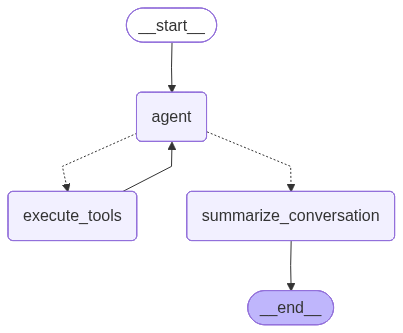

In [39]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

# Display a visualization of our graph
try:
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("The graph structure is: classification_node -> entity_extraction -> summarization -> END")

 ## Testing the Main Agent Loop

 Let's put our travel agent to work! The main loop handles the conversation flow:

 **Initialization**: Sets up a unique thread ID and empty message state

 **Input Processing**: Gets user input, handles empty inputs, and exit commands  

 **Message Flow**: Converts input to HumanMessage and streams through our workflow

  **Response Generation**: Processes state and displays AI responses

 **Error Handling**: Catches errors and keeps the conversation flowing smoothly



In [40]:
def main(thread_id: str = "book_flight", user_id: str = "demo_user"):
    """Main interaction loop for the travel agent"""

    print("Welcome to the Travel Assistant! (Type 'exit' to quit)")

    config = RunnableConfig(configurable={"thread_id": thread_id, "user_id": user_id})
    state = RuntimeState(messages=[])

    # Make sure logs actually show up in Colab
    import logging
    logging.basicConfig(level=logging.INFO)
    logger.setLevel(logging.INFO)

    while True:
        user_input = input("\nYou (type 'quit' to quit): ")

        if not user_input:
            continue

        if user_input.lower() in ["exit", "quit"]:
            print("Thank you for using the Travel Assistant. Goodbye!")
            break

        # Store + echo the user message
        state["messages"].append(HumanMessage(content=user_input))
        # print(f"You: {user_input}")

        try:
            # Stream through the graph and print messages as they arrive
            last_state = None
            for result in graph.stream(state, config=config, stream_mode="values"):
                last_state = RuntimeState(**result)

                # Get the most recent message and show it
                if last_state["messages"]:
                    last_msg = last_state["messages"][-1]

                    # Tool/API calls
                    if getattr(last_msg, "type", None) == "tool" or last_msg.__class__.__name__ == "ToolMessage":
                        # Name attribute may differ depending on your stack
                        tool_name = getattr(last_msg, "name", "tool")
                        print(f"[Tool: {tool_name}] {last_msg.content}")

                    # Assistant messages
                    elif isinstance(last_msg, AIMessage):
                        print(f"Assistant: {last_msg.content}")

                    # Human messages (often not needed, but included for completeness)
                    elif isinstance(last_msg, HumanMessage):
                        print(f"You (state): {last_msg.content}")

            if last_state is not None:
                state = last_state

            logger.info(f"# of messages after run: {len(state['messages'])}")

        except Exception as e:
            logger.exception(f"Error processing request: {e}")
            error_message = "I'm sorry, I encountered an error processing your request."
            print(f"\nAssistant: {error_message}")
            state["messages"].append(AIMessage(content=error_message))


Before you try your own, take a look at the current conversation between Tyler and the travel agent. Notice the memory storage actions, the calls to the LLM, and also the conversation summarization that take place during the workflow!

In [74]:
# Delete all memories (documents) from this index, keep the index/schema
deleted_count = long_term_memory_index.clear()
print("Deleted memories:", deleted_count)


Deleted memories: 1


In [75]:
try:
    user_id = input("Enter a user ID: ") or "demo_user"
    thread_id = input("Enter a thread ID: ") or "demo_thread"
except Exception:
    # If we're running in CI, we don't have a terminal to input from, so just exit
    exit()
else:
    main(thread_id, user_id)


Welcome to the Travel Assistant! (Type 'exit' to quit)
You (state): Hi I plan to go to singapore with my wife this summer. We love outdoors activities and trying new kinds of foods. Any good recommendations?


INFO:__main__:Preparing to store memory: User is planning a summer trip to Singapore with their wife. They love outdoor activities and trying new kinds of foods; traveling as a couple.
INFO:__main__:Stored MemoryType.EPISODIC memory: User is planning a summer trip to Singapore with their wife. They love outdoor activities and trying new kinds of foods; traveling as a couple.
INFO:__main__:# of messages after run: 2


Assistant: Fantastic choice—Singapore is perfect for couples who love the outdoors and food. Here are curated ideas to mix nature, culture, and great eats.

Outdoor highlights
- Pulau Ubin and Chek Jawa: Rent bikes, explore kampong trails, and do a guided mangrove kayak. Feels like stepping back in time.
- Southern Ridges to Henderson Waves: 10km of scenic elevated walks; go late afternoon for sunset views.
- MacRitchie Reservoir: Forest hike with the TreeTop Walk suspension bridge (check opening days/hours).
- Gardens by the Bay: Stroll the outdoor gardens; catch the Garden Rhapsody light show at night. OCBC Skyway is a fun add-on.
- Marina Barrage: Pack a picnic or fly kites at sunset with skyline views.
- East Coast Park: Cycle the coastal path; plenty of seaside cafes and seafood spots.
- Sentosa: Beach day + stand-up paddleboarding or kayaking at Ola Beach Club; add the Fort Siloso Skywalk or the Skyline Luge.
- Mandai wildlife evenings: Night Safari for a unique after-dark experi

INFO:__main__:Preparing to store memory: User is planning a summer trip to Singapore with their spouse and enjoys outdoor activities and trying new foods.
INFO:__main__:Similar memory found, skipping storage
INFO:__main__:# of messages after run: 4


Assistant: Great idea—there’s no nonstop from ATL to SIN, so the best routes are 1-stop via the West Coast, Northeast Asia, the Middle East, or Europe. Here are the most popular and reliable options from Atlanta, with pros and typical total times.

Fastest 1-stop options
- United via SFO or LAX: ATL → SFO/LAX → SIN
  - Pros: One-stop, very fast; good on-time performance; many flight times.
  - Notes: Nonstop SFO–SIN and LAX–SIN on United. Total ~22–24.5 hrs.
- Singapore Airlines via West Coast: ATL → SFO/LAX/SEA → SIN
  - Pros: Excellent service/food; true long-haul comfort.
  - Notes: Nonstops on SQ from SFO, LAX, and SEA. Total ~23–25 hrs. Consider a longer layover or overnight on the West Coast to protect the connection.

Northeast Asia (great service and smooth transits)
- Korean Air via Seoul (ICN): ATL → ICN → SIN
  - Pros: Easy, well-run hub; good schedules; strong SkyTeam option.
  - Time: ~23–26 hrs.
- ANA or JAL via Tokyo (HND/NRT): ATL → US hub (ORD/IAD/DFW/LAX) → HND/NRT → 

INFO:__main__:Preparing to store memory: User prefers Delta and aims to sit in first/business class when possible.
INFO:__main__:Stored MemoryType.EPISODIC memory: User prefers Delta and aims to sit in first/business class when possible.


Assistant: Short answer: Yes, but manage expectations—long-haul “first class” to Singapore is really business class, and complimentary upgrades don’t apply on those routes. Your best upgrade paths as Delta loyalists are via SkyTeam partners and/or using instruments or miles.

What typically works from ATL to SIN
- Delta + Air France/KLM via Europe (ATL → CDG/AMS → SIN)
  - Upgrade options: Strongest for Delta flyers.
    - Global Upgrade Certificates (GUCs, Diamond Choice Benefit) can be applied on DL/AF/KL if upgrade inventory opens; you can waitlist.
    - Paid or miles-for-upgrade offers sometimes appear on AF/KL close to departure or at check-in.
  - Complimentary Medallion Upgrades: Not on Delta One transatlantic; only on domestic segments.
- Delta + Korean Air via Seoul (ATL → ICN → SIN)
  - Upgrade options: Possible with GUCs but much tighter and often requires higher fare classes; space is scarce.
  - Paid day-of upgrades appear occasionally but can be pricey.
- West Coast to S

INFO:__main__:Summarized 6 messages into a conversation summary
INFO:__main__:# of messages after run: 2


You (state): Let's hold on booking for now. Back to activities. Based on what you know about me, what do you think we should do? Design the perfect Sunday for me and my wife in Singapore.


INFO:__main__:Preparing to store memory: User and spouse enjoy outdoor activities and trying local foods; they’re planning a Singapore trip for the summer.
INFO:__main__:Similar memory found, skipping storage
INFO:__main__:# of messages after run: 4


Assistant: Love it. Based on what I know—you two like being outdoors and trying local foods—here’s a Sunday that beats the heat, mixes wild nature with iconic city green space, and ends with classic Singapore night vibes.

Perfect Sunday plan
- 7:30 am – Changi Village breakfast
  - Taxi to Changi Village Hawker Centre (30–40 min).
  - What to order: Nasi lemak (Mizzy or International), kopi/teh, kaya toast if you want something lighter.
  - Tip: Bring some cash; a few stalls prefer it.

- 8:30–11:15 am – Pulau Ubin cycling + Chek Jawa
  - Bumboat from Changi Point Ferry Terminal (cash, shared boats go when ~12 pax; S$4 pp).
  - Rent bikes at Ubin jetty. Easy ride to Chek Jawa Boardwalk for mangroves, coastal views, and wildlife.
  - Notes: Wear breathable clothes, sunscreen, insect repellent; carry water. Check tide times if you can—Chek Jawa is best at lower tide.

- 11:45 am – Coconut/iced drinks back at Changi Village
  - Quick cool-down and snack before heading into town.

- 12:30

INFO:__main__:Preparing to store memory: User’s wife has a severe shellfish allergy; avoid recommending shellfish dishes and note belacan/shrimp paste risks in Singapore food suggestions.
INFO:__main__:Stored MemoryType.EPISODIC memory: User’s wife has a severe shellfish allergy; avoid recommending shellfish dishes and note belacan/shrimp paste risks in Singapore food suggestions.


Assistant: Got it—no shellfish. I’ll keep belacan/shrimp paste off the table too. Here’s a Sunday that keeps the outdoorsy vibe and swaps in allergy-safe eats.

Your shellfish-safe Sunday
- 7:30 am – Changi Village breakfast
  - Kaya toast + kopi/teh, or nasi lemak with chicken wing/egg/cucumber. Ask for no sambal (often has shrimp paste).
  - Cash for a few stalls.

- 8:30–11:15 am – Pulau Ubin cycling + Chek Jawa
  - Bumboat from Changi Point (cash). Easy ride to boardwalks; bring water, sunscreen, repellent.

- 11:45 am – Cool-down drink back at Changi Village
  - Fresh coconut, sugarcane juice, or iced coffee/tea.

- 12:30–2:00 pm – Joo Chiat/Katong food + shophouses
  - Mr & Mrs Mohgan’s Super Crispy Roti Prata (get egg or plain with chicken curry) or Katong Mei Wei Boneless Chicken Rice.
  - Sweets: Chin Mee Chin Confectionery (kaya buns) or Birds of Paradise gelato.
  - Stroll Koon Seng Road for Peranakan facades.

- 2:15–3:45 pm – Gardens by the Bay (A/C break)
  - Cloud Forest

INFO:__main__:Summarized 6 messages into a conversation summary
INFO:__main__:# of messages after run: 2


You (state): Excellent. Back to booking flights. For our preferred airline, will you recommend best route to get there from the US?


INFO:__main__:Preparing to store memory: User departs from Atlanta (ATL), is loyal to Delta, and travels with a spouse who has a severe shellfish allergy.
INFO:__main__:Stored MemoryType.EPISODIC memory: User departs from Atlanta (ATL), is loyal to Delta, and travels with a spouse who has a severe shellfish allergy.
INFO:__main__:# of messages after run: 4


Assistant: Best Delta-loyalist routes to Singapore (ranked)

1) Via Amsterdam (fastest, smoothest for upgrades)
- ATL → AMS on Delta or KLM, then AMS → SIN nonstop on KLM
- Why: Usually the shortest total travel time from ATL, easy 1-stop, strong schedule, GUCs/miles can be applied on KL (subject to upgrade space). AMS is an efficient connection.
- Tip: Aim for 90–150 min layover in AMS.

2) Via Paris
- ATL → CDG on Delta or Air France, then CDG → SIN nonstop on Air France
- Why: Solid 1-stop option with AF’s A350 business cabin; GUCs/miles can be used on AF when space opens. CDG has more banked connections from ATL.
- Tip: 2–3 hours at CDG is comfortable for terminal changes and security.

3) Via Seoul (great service, very reliable)
- ATL (or DTW/SEA) → ICN on Delta, then ICN → SIN on Korean Air
- Why: Excellent on-time performance and an easy same-terminal transfer at ICN. GUCs can be used on KE when available; KE service is consistently good.
- Trade-off: Often a touch longer than E

INFO:__main__:Preparing to store memory: User last visited Singapore at age 15 on a family trip for their father's business and had a great time.
INFO:__main__:Stored MemoryType.EPISODIC memory: User last visited Singapore at age 15 on a family trip for their father's business and had a great time.


Assistant: Love it—and I’m excited to get you back to Singapore in style.

Just to confirm: when you say “this one,” do you mean the AMS routing (ATL → Amsterdam on Delta/KLM, then KLM nonstop AMS → Singapore)? I’ll set that as Plan A, with Paris (AF) or Seoul (KE) as backups if needed.

To pull the best flights and upgrade angles, can you share:
- Dates: target departure/return or a 2–3 day range each way, plus flexibility (+/– days)
- Delta details: Medallion tier and whether you have any Global Upgrade Certificates; rough SkyMiles balance
- Booking floor: what cabin you’re comfortable purchasing if upgrades don’t clear (Main vs Premium Select vs Business)
- Layover style: quick 90–150 minutes or a more relaxed 2–4 hours? Open to a short stopover in Amsterdam, or keep it 1-stop same day?
- Seats: window/aisle preferences and whether you want to sit together or across the aisle
- Meals: okay for me to add a shellfish-allergy note and pre-select non-seafood meal options on the long leg

INFO:__main__:Summarized 6 messages into a conversation summary
INFO:__main__:# of messages after run: 2



You (type 'quit' to quit): quit
Thank you for using the Travel Assistant. Goodbye!


Let's review what the agent learned about me during the process!

In [76]:
res = retrieve_memories_tool.invoke({"query": "Travel, activity, and dietary preferences", "memory_type": ["episodic", "semantic"]})
res.split("\n")

['Long-term memories:',
 '- [MemoryType.EPISODIC] User is planning a summer trip to Singapore with their wife. They love outdoor activities and trying new kinds of foods; traveling as a couple.',
 '- [MemoryType.EPISODIC] User departs from Atlanta (ATL), is loyal to Delta, and travels with a spouse who has a severe shellfish allergy.',
 "- [MemoryType.EPISODIC] User last visited Singapore at age 15 on a family trip for their father's business and had a great time.",
 '- [MemoryType.EPISODIC] User prefers Delta and aims to sit in first/business class when possible.',
 '- [MemoryType.EPISODIC] User’s wife has a severe shellfish allergy; avoid recommending shellfish dishes and note belacan/shrimp paste risks in Singapore food suggestions.']

Don't forget, we have the RedisVL index we can use to manually query or work with as needed:

In [77]:
from redisvl.query import CountQuery

# count total long-term memories in Redis
long_term_memory_index.query(CountQuery())

5

___

# 🎓 Recap

You've now learned the fundamentals from scratch and built a **production-ready memory-enabled AI agent** from the ground up. Let's recap the key accomplishments:

## 🏗️ What we built

1. ✅ **Dual-Memory Architecture**: Short-term conversation state + long-term persistent knowledge with LangGraph and Redis
2. ✅ **Vector-Powered Memory**: Semantic search using RedisVL
3. ✅ **Smart Deduplication**: Prevents storing similar memories multiple times  
4. ✅ **Tool-Based Memory Management**: LLM controls when to store/retrieve memories  
5. ✅ **Conversation Summarization**: Automatic context window management  

**Why Redis?**

- **Performance**: Sub-millisecond memory retrieval at scale  
- **Versatility**: Handles both structured state (checkpoints) and unstructured data (vectors)  
- **Production-Ready**: Built-in persistence, clustering, and high availability  
- **Developer Experience**: Rich ecosystem with tools like RedisVL and AI framework integrations  

## 🔧 Alternative memory dev frameworks

While this notebook shows hands-on implementation, consider these frameworks for faster development:

- **[LangMem](https://github.com/langchain-ai/langmem)**: LangChain's official memory framework
- **[Mem0](https://github.com/mem0-ai/mem0)**: Dedicated memory layer for AI applications

**When to Use Each Approach:**
- **Custom Implementation** (this tutorial): Maximum control, specific requirements, learning
- **LangMem**: LangChain ecosystem integration, rapid prototyping
- **Mem0**: Multi-application memory sharing, enterprise features
